In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class Config():
    training_dir = "./drive/MyDrive/Datasets/Cropped_lfw_correct"
    testing_dir = "./drive/MyDrive/Datasets/Cropped_lfw_correct"
    train_batch_size = 64
    train_number_epochs = 25
    training_txt="./drive/MyDrive/Datasets/LWF_DATASET/pairsDevTrainMod.txt"
    testing_txt="./drive/MyDrive/Datasets/LWF_DATASET/pairsDevValidMod.txt"

In [5]:
class SiameseNetworkDataset():
    
    def __init__(self,training_txt=None,training_dir=None,transform=None):
        # training_dir,transform,training_pairs
        self.training_dir = training_dir    
        self.transform = transform
        
        with open(training_txt) as f:
          lines=f.readlines()
          self.training_pairs=[  line.split()       for line in lines  ] 
          for i in range(len(self.training_pairs)):
            self.training_pairs[i][2]=int(self.training_pairs[i][2])

    def __getitem__(self,index):
        
        # getting the image path
        image_pair= self.training_pairs[index]
        image1_path=os.path.join(self.training_dir,image_pair[0])
        image2_path=os.path.join(self.training_dir,image_pair[1])
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        
        # Apply image transformations
        if self.transform :
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int( image_pair[2] )],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_pairs)

In [6]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(Config().training_txt,Config().training_dir,
                                        transform=transforms.Compose([transforms.Resize(( 224,224 )),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

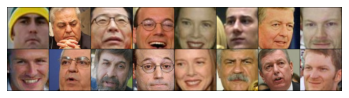

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [7]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [8]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork,self).__init__()

    model_conv=torchvision.models.resnet50(pretrained=True)
    for param in model_conv.parameters():
      param.requires_grad=False
    self.num_ftrs=model_conv.fc.in_features

    self.res_net_conv=torch.nn.Sequential(*(list(model_conv.children())[:-1]))

    self.fc=nn.Sequential(
        nn.Linear(self.num_ftrs,128),
        nn.Linear(128,2)
    )


  def forward(self,x1,x2):
    x1= self.res_net_conv(x1)
    x2= self.res_net_conv(x2)

    x1=x1.view(-1,self.num_ftrs)
    x2=x2.view(-1,self.num_ftrs)

    x1=self.fc(x1)
    x2=self.fc(x2)

    return x1,x2

In [9]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')


In [10]:
siameseNetwork=SiameseNetwork()

count_parameters(siameseNetwork)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



The model architecture:

 SiameseNetwork(
  (res_net_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [ ]:
# class ContrastiveLoss(torch.nn.Module):
#     """
#     Contrastive loss function.
#     Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
#     """

#     def __init__(self, margin=2.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, output1, output2, label):
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

#         return loss_contrastive

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
      super(ContrastiveLoss, self).__init__()
      self.margin = margin

    def forward(self, output1,output2, label):
      dist = F.pairwise_distance(output1, output2)
      loss = torch.mean(1/2*(label) * torch.pow(dist, 2) +
                                      1/2*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))
      return loss

In [12]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=Config().train_batch_size)

In [13]:
if torch.cuda.is_available():
  device='cuda:0'
  print('Running on gpu')
else:
  device='cpu'
  print('Running on cpu')

Running on gpu


In [14]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.Adam(net.fc.parameters(), lr=0.0005)
# optimizer = optim.RMSprop(net.fc.parameters(), lr=0.0005, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)
count_parameters(net)

The model architecture:

 SiameseNetwork(
  (res_net_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [15]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config().train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net,loss_history

In [16]:
# Train the model
model,loss_history = train()
torch.save(model.state_dict(), "/content/model.pt")
print("Model Saved Successfully")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch number 0
 Current loss 0.8233470320701599

Epoch number 1
 Current loss 0.5614961981773376

Epoch number 2
 Current loss 0.5778382420539856

Epoch number 3
 Current loss 0.5304635763168335

Epoch number 4
 Current loss 0.5668001770973206

Epoch number 5
 Current loss 0.6001392602920532

Epoch number 6
 Current loss 0.5501312017440796

Epoch number 7
 Current loss 0.5304997563362122

Epoch number 8
 Current loss 0.5507776737213135

Epoch number 9
 Current loss 0.5558383464813232

Epoch number 10
 Current loss 0.5625999569892883

Epoch number 11
 Current loss 0.5500646233558655

Epoch number 12
 Current loss 0.5588006973266602

Epoch number 13
 Current loss 0.566757082939148

Epoch number 14
 Current loss 0.5348808765411377

Epoch number 15
 Current loss 0.5458630323410034

Epoch number 16
 Current loss 0.5434412956237793

Epoch number 17
 Current loss 0.5613558292388916

Epoch number 18
 Current loss 0.5531487464904785

Epoch number 19
 Current loss 0.5460668802261353

Epoch numbe

# Best so far

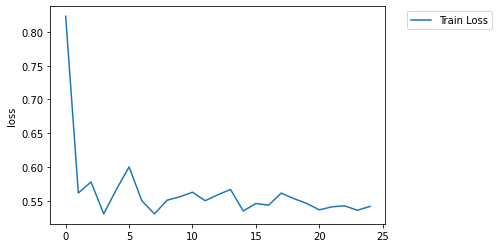

In [17]:
# lr= 0.0005   batch=64   epoch=25
plt.ylabel('loss')
plt.plot(loss_history, label='Train Loss')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

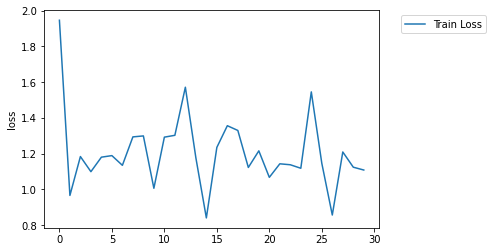

In [ ]:
# lr= 0.00005
plt.ylabel('loss')
plt.plot(loss_history, label='Train Loss')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

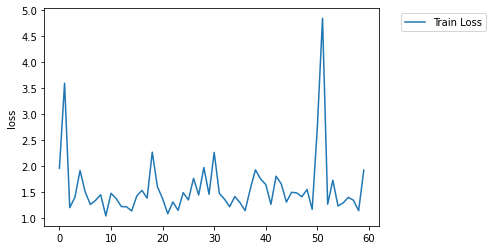

In [ ]:
# lr= 0.001
plt.ylabel('loss')
plt.plot(loss_history, label='Train Loss')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

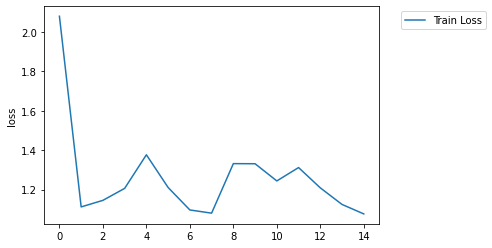

In [ ]:
# lr= 0.0001
plt.ylabel('loss')
plt.plot(loss_history, label='Train Loss')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
# Load the saved model
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("/content/model.pt"))

<All keys matched successfully>

In [ ]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(Config().testing_txt,Config().testing_dir,
                                        transform=transforms.Compose([transforms.Resize(( 224,224 )),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=2,batch_size=1,shuffle=True)

In [ ]:
# wrong code

# accuracy=0
# counter=0
# correct=0
# for i, data in enumerate(test_dataloader,0): 
#   x0, x1 , label = data
#   # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
#   output1,output2 = model(x0.to(device),x1.to(device))
#   res=torch.abs(output1.cuda() - output2.cuda())
#   label=label[0].tolist()
#   label=int(label[0])
#   result=torch.max(res,1)[1][0][0][0].data[0].tolist()
#   print(result)
#   if label == result:
#     correct=correct+1
#   counter=counter+1
#    if counter ==20:
#       break
# accuracy=(correct/len(test_dataloader))*100
# print("Accuracy:{}%".format(accuracy))